 This notebook contains tests for the GLM beta parameter. From the meeting with Dario, Tiago and Yulin on Dec 11 2023 we have:
 
summarising conclusions from the discussion: </br>
checking eg log likelihood ratio change at each iteration to decide when model has converged </br>
including beta in regularsation</br>
regularisation to encourage sparseness of parameters </br>
spike history </br>
""Vm"": filtering PAG spikes with some kernel that looks like: ramp before spike (like, eg 10ms), steep and rapid decrease (like, 2ms) after spike, as a substitute for spike history </br>

In [17]:
import numpy as np
from glm import BernoulliGLMPyTorch
import pandas as pd
import pickle

from utils import *

import torch
import torch.nn as nn
import torch.distributions as dist
seed = 1234
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [18]:
sim_data_path = './sim/save/pagsim_w_stimuli_1s_inh/'
brain_regions = [
                'VMH',
                'ACC',
                'IC',
                'SC',
                'PMD'
                ]
presyn_binned = np.load(sim_data_path+'presyn_binned.npy')
presyn_smooth = np.load(sim_data_path+'presyn_exponential_smooth.npy')
bin_size = 0.001
n_input_neurons, n_bins = presyn_binned.shape
n_neurons_per_group = np.load(sim_data_path+'n_neurons_per_group.npy')
_total_length = n_bins / 1000
# load actual connecticity: shape (n_brain_region * n_PAG * n_connections)
with open(f'{sim_data_path}conns.pkl', 'rb') as f:
    conns = pickle.load(f)
    
_range = 200 #ms
_random_start = np.random.randint(1000-_range)

### Test 1: fix beta (on 1 PAG , exp filtering)

In [3]:
n_PAG_to_use = 1 # specify how many PAG neurons to learn

pag_df = extract_sim_as_df(sim_data_path, 'PAG')
pag_timings = extract_timings(pag_df, 'PAG')
pag_binned_spikes = bin_spikes(pag_timings, start_time=0, end_time=_total_length, bin_size=0.001)[:n_PAG_to_use]
print(f'Average PAG firing rate: {np.sum(pag_binned_spikes) / pag_binned_spikes.shape[0] / _total_length} Hz.')

2023-12-20 12:04:45.202 | DEBUG    | utils:bin_spikes:63 - Created spike bin matrix with 8 neurons and 1000 bins. Total number of spikes: 41.0


Average PAG firing rate: 12.0 Hz.


In [4]:
# construct input and output matrices
train_start = 0
train_end = 0.8
test_start = 0.8
test_end = 1.001
# for pag_stim_w_stimuli, external pulses are delivered from 40 mins to 60 mins, 10 secs each, lasting 1 sec
train_bins = int((train_end - train_start) / bin_size)
test_bins = int((test_end - test_start) / bin_size)

X_train, X_test = np.zeros((n_input_neurons*n_PAG_to_use, n_PAG_to_use * train_bins)), np.zeros((n_input_neurons*n_PAG_to_use, n_PAG_to_use * test_bins))
y_train, y_test = np.zeros((1, train_bins * n_PAG_to_use)), np.zeros((1, test_bins * n_PAG_to_use))

for n in range(n_PAG_to_use):
    X_train[n_input_neurons*n:n_input_neurons*(n+1), n * train_bins: (n+1) * train_bins] = presyn_smooth[:, int(train_start/bin_size):int(train_end/bin_size)] # chunks of n_neurons * train_set_bin_size
    X_test[n_input_neurons*n:n_input_neurons*(n+1), n * test_bins :(n+1) * test_bins] = presyn_smooth[:, int(test_start/bin_size):int(test_end/bin_size)]
    
    y_train[:, n * train_bins: (n+1)* train_bins] = pag_binned_spikes[n, int(train_start/bin_size): int(train_end/bin_size)]
    y_test[:, n * test_bins: (n+1)* test_bins] = pag_binned_spikes[n, int(test_start/bin_size): int(test_end/bin_size)]
assert X_train.shape[1] == y_train.shape[1]
assert X_test.shape[1] == y_test.shape[1]

print('Number of PAG spikes in the training set: ', np.sum(y_train))
print('Number of PAG spikes in the test set: ', np.sum(y_test))

Number of PAG spikes in the training set:  10.0
Number of PAG spikes in the test set:  2.0


In [16]:
glm = BernoulliGLMPyTorch(
    group_names=brain_regions,
    n_neurons_per_group=np.array([64, 64, 64, 64, 64]),
    link_fn='logistic',
    n_sessions=n_PAG_to_use,
    regs = ['weights_within_group'],
    reg_params={'weights_within_group':np.array([1,1,1,1,1]),
               },
    ).to(device)

glm.linear.bias.data = torch.tensor([-10.]).to(device)
glm.linear.bias.requires_grad = False

# glm._load_state_dict(torch.load(f'{sim_data_path}sing_exp_reg1_beta=-100.pth'))

glm.fit(X_train.T, y_train.T, n_iter=40000, lr=1e-3, verbose=1, decay=0.9999)
glm.load_best_params()
torch.save(glm.state_dict(), f'{sim_data_path}sing_exp_reg1_beta=-100.pth')

2023-12-15 13:10:43.600 | DEBUG    | glm:fit:316 - Training GLM with PyTorch. Initial log like: 133241.265625, loss 133241.328125, of which regs [0.0650406, 0.0, 0.0] respectively for ['weights_within_group', 'weights_sparsity', 'beta'].
2023-12-15 13:11:19.629 | DEBUG    | glm:fit:343 - Step 2000. Log like: 45870.171875, loss 46273.9140625, of which regs [403.7433, 0.0, 0.0] respectively for ['weights_within_group', 'weights_sparsity', 'beta'].
2023-12-15 13:11:50.840 | DEBUG    | glm:fit:343 - Step 4000. Log like: 45515.11328125, loss 46146.18359375, of which regs [631.07043, 0.0, 0.0] respectively for ['weights_within_group', 'weights_sparsity', 'beta'].
2023-12-15 13:12:13.695 | DEBUG    | glm:fit:343 - Step 6000. Log like: 45514.46484375, loss 46146.18359375, of which regs [631.7195, 0.0, 0.0] respectively for ['weights_within_group', 'weights_sparsity', 'beta'].
2023-12-15 13:12:37.226 | DEBUG    | glm:fit:343 - Step 8000. Log like: 45514.4609375, loss 46146.18359375, of which re

KeyboardInterrupt: 

In [17]:
glm_w, glm_b = glm.best_weight.cpu().numpy(), glm.best_bias.cpu().numpy() # shape (1, 320), (1,)
print('Learned bias:', glm_b)
print('y-intercept:', 1/(1+np.exp(-glm_b)))

Learned bias: [-10.]
y-intercept: [4.539787e-05]


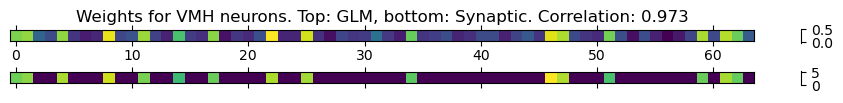

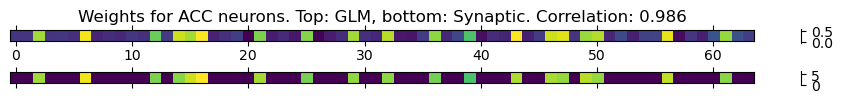

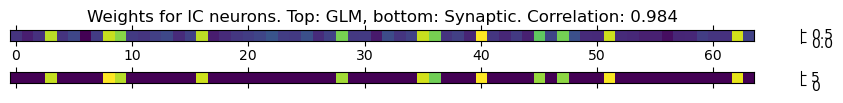

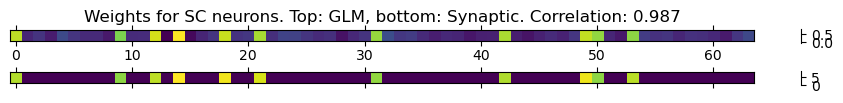

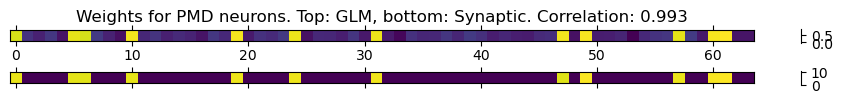

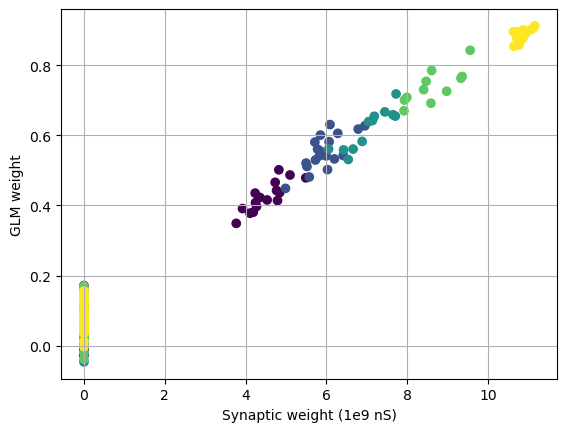

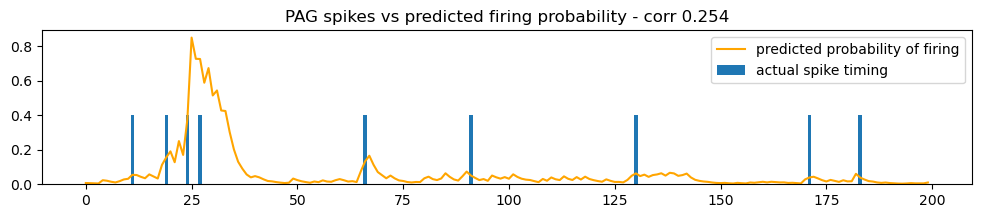

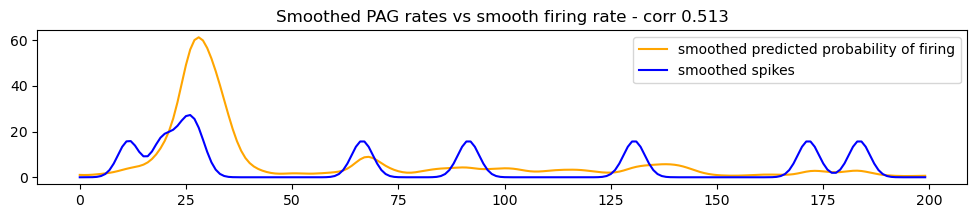

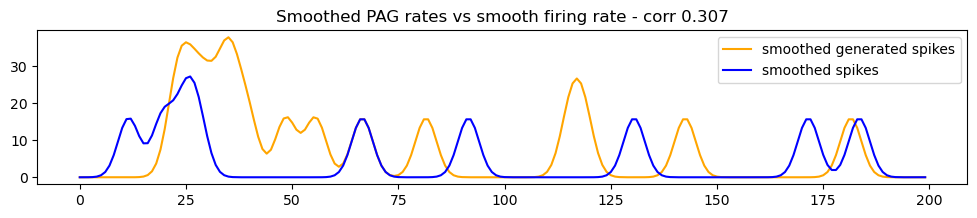

In [18]:
# comparison with actual connectivity
for m, brain_region in enumerate(brain_regions):
    
    corr = np.corrcoef(glm_w[..., glm.group_synapse_idx[m]], conns[m, :n_PAG_to_use, :])[0,1]
    f, axes = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(12,1))
    mat1 = axes[0].matshow(glm_w[..., glm.group_synapse_idx[m]])
    f.colorbar(mat1, shrink=0.4)
    axes[0].set_title(f'Weights for {brain_region} neurons. Top: GLM, bottom: Synaptic. Correlation: {str(corr)[:5]}')
    axes[0].set_yticks([])

    mat2 = axes[1].matshow(conns[m, :n_PAG_to_use, :])
    f.colorbar(mat2, shrink=0.4)
    axes[1].set_yticks([])
plt.show()

# scatter plot of all learned weights
plt.scatter(conns[:,:n_PAG_to_use,:].flatten(), glm_w, c=glm.synapse_origin_group)
plt.xlabel('Synaptic weight (1e9 nS)')
plt.ylabel('GLM weight')
plt.grid()
plt.show()

# test set prediction
with torch.no_grad():
    y_test_hat = glm(X_test.T).T # (1 PAG neuron * 100 secs)
    

plt.figure(figsize=(12,2))
plt.plot(y_test_hat.cpu()[0,_random_start:_random_start + _range], label='predicted probability of firing', color='orange')
plt.bar(np.arange(_range), y_test[0,_random_start:_random_start + _range]*0.4, label='actual spike timing')
plt.legend()
plt.title(f'PAG spikes vs predicted firing probability - corr {str(np.corrcoef(y_test, y_test_hat.cpu())[0,1])[:5]}')
plt.show()

generated_spikes = generate_bernoulli_spikes(y_test_hat)

smooth_y_test = rbf_rate_convolution_1d(y_test[0], sigma=0.025, dt=0.01)                                        # smooth test set spikes
smooth_y_test_hat = rbf_rate_convolution_1d(y_test_hat[0].cpu(), sigma=0.025, dt=0.01)                          # smooth predicted probabilities
smooth_y_test_hat_generated_spikes = rbf_rate_convolution_1d(generated_spikes[0].cpu(), sigma=0.025, dt=0.01)   # smooth generated spikes

plt.figure(figsize=(12,2))
plt.plot(smooth_y_test_hat[_random_start:_random_start + _range], label='smoothed predicted probability of firing', color='orange')
plt.plot(smooth_y_test[_random_start:_random_start + _range], label='smoothed spikes', color='blue')
plt.legend()
plt.title(f'Smoothed PAG rates vs smooth firing rate - corr {str(np.corrcoef(smooth_y_test_hat, smooth_y_test)[0,1])[:5]}')
plt.show()

plt.figure(figsize=(12,2))
plt.plot(smooth_y_test_hat_generated_spikes[_random_start:_random_start + _range], label='smoothed generated spikes', color='orange')
plt.plot(smooth_y_test[_random_start:_random_start + _range], label='smoothed spikes', color='blue')
plt.legend()
plt.title(f'Smoothed PAG rates vs smooth firing rate - corr {str(np.corrcoef(smooth_y_test_hat_generated_spikes, smooth_y_test)[0,1])[:5]}')
plt.show()

### Test 2.1 : Add regularisation term on beta
beta regularisation: 1 * beta**2 + n * beta ** (-3)

In [8]:
glm = BernoulliGLMPyTorch(
    group_names=brain_regions,
    n_neurons_per_group=np.array([64, 64, 64, 64, 64]),
    link_fn='logistic',
    n_sessions=n_PAG_to_use,
    regs = ['weights_within_group', 'beta'],
    reg_params={'weights_within_group':np.array([1,1,1,1,1]),
                'beta':np.array([100,0,1,0])
               },
    ).to(device)


# glm._load_state_dict(torch.load(f'{sim_data_path}sing_exp_reg1_betareg=2,3.pth'))

glm.fit(X_train.T, y_train.T, n_iter=40000, lr=1e-3, verbose=1, decay=0.9999)
# glm.load_best_params()
# torch.save(glm.state_dict(), f'{sim_data_path}sing_exp_reg1_betareg=2,3.pth')
with torch.no_grad():
    print(glm.calc_log_likelihood_w_reg(X_train.T, y_train.T, return_components=True))

2023-12-15 12:43:40.677 | DEBUG    | glm:fit:316 - Training GLM with PyTorch. Initial log like: 203313.8125, loss 203309.59375, of which regs [0.054738425, 0.0, -4.280692] respectively for ['weights_within_group', 'weights_sparsity', 'beta'].
2023-12-15 12:44:20.645 | DEBUG    | glm:fit:343 - Step 2000. Log like: 51651.640625, loss 51664.1796875, of which regs [41.406387, 0.0, -28.868324] respectively for ['weights_within_group', 'weights_sparsity', 'beta'].
2023-12-15 12:45:00.976 | DEBUG    | glm:fit:343 - Step 4000. Log like: 49384.046875, loss 49641.6953125, of which regs [325.48407, 0.0, -67.833916] respectively for ['weights_within_group', 'weights_sparsity', 'beta'].
2023-12-15 12:45:40.965 | DEBUG    | glm:fit:343 - Step 6000. Log like: 48596.19921875, loss 48843.18359375, of which regs [380.85062, 0.0, -133.86462] respectively for ['weights_within_group', 'weights_sparsity', 'beta'].
2023-12-15 12:46:20.617 | DEBUG    | glm:fit:343 - Step 8000. Log like: 47825.89453125, loss 4

(tensor(45510.3203, device='cuda:0'), tensor([ 475.3265,    0.0000, -620.1299], device='cuda:0'))


In [9]:
glm_w, glm_b = glm.best_weight.cpu().numpy(), glm.best_bias.cpu().numpy() # shape (1, 320), (1,)
print('Learned bias:', glm_b)
print('y-intercept:', 1/(1+np.exp(-glm_b)))

Learned bias: [-6.201299]
y-intercept: [0.0020227]


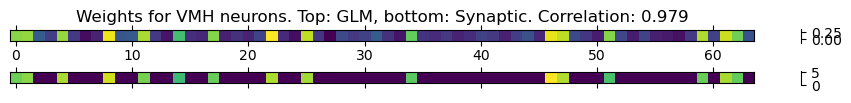

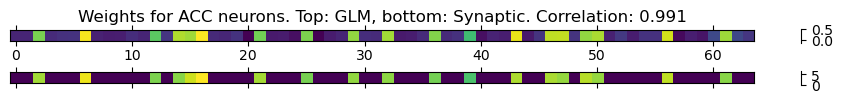

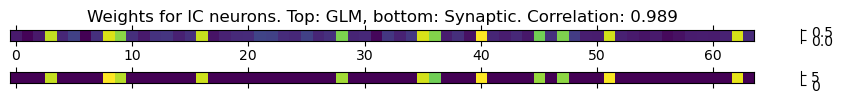

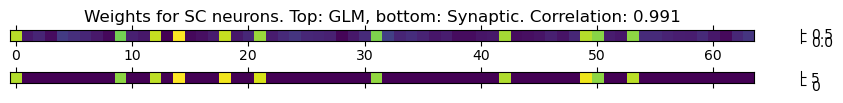

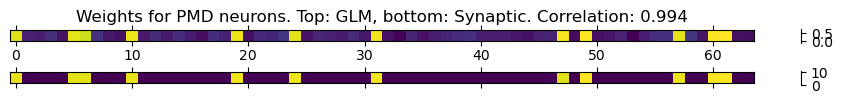

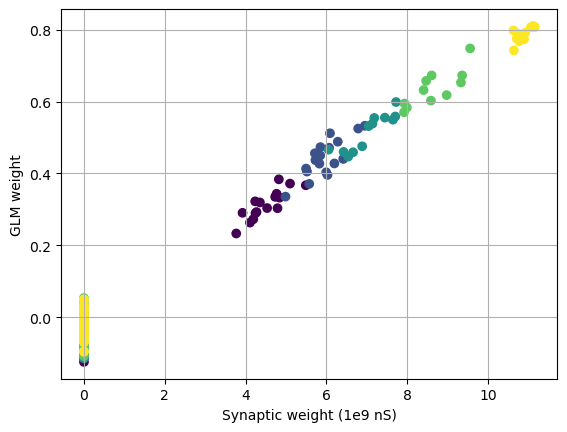

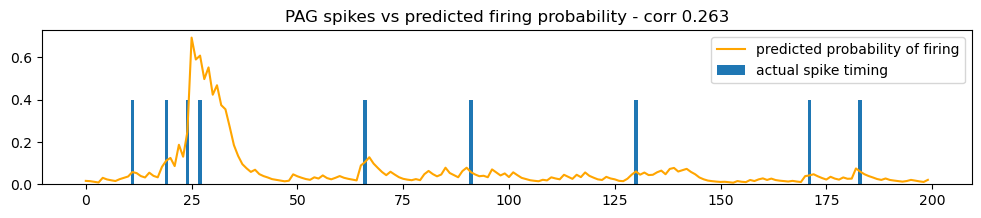

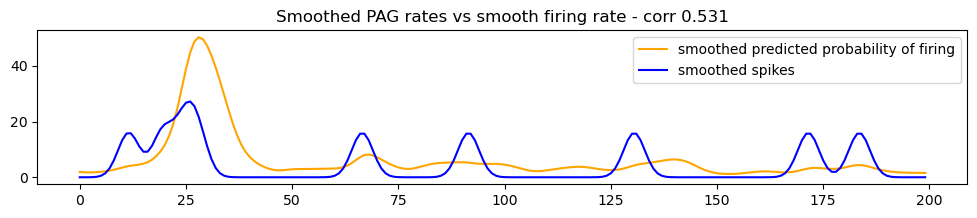

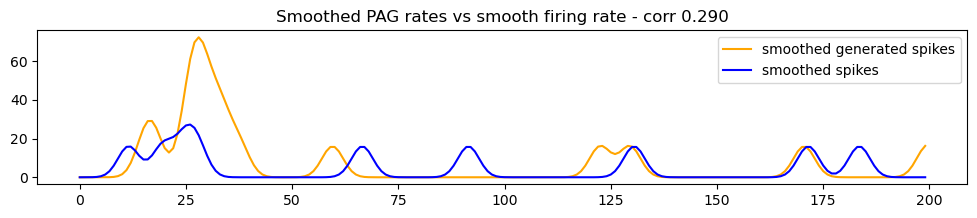

In [11]:
# comparison with actual connectivity
for m, brain_region in enumerate(brain_regions):
    
    corr = np.corrcoef(glm_w[..., glm.group_synapse_idx[m]], conns[m, :n_PAG_to_use, :])[0,1]
    f, axes = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(12,1))
    mat1 = axes[0].matshow(glm_w[..., glm.group_synapse_idx[m]])
    f.colorbar(mat1, shrink=0.4)
    axes[0].set_title(f'Weights for {brain_region} neurons. Top: GLM, bottom: Synaptic. Correlation: {str(corr)[:5]}')
    axes[0].set_yticks([])

    mat2 = axes[1].matshow(conns[m, :n_PAG_to_use, :])
    f.colorbar(mat2, shrink=0.4)
    axes[1].set_yticks([])
plt.show()

# scatter plot of all learned weights
plt.scatter(conns[:,:n_PAG_to_use,:].flatten(), glm_w, c=glm.synapse_origin_group)
plt.xlabel('Synaptic weight (1e9 nS)')
plt.ylabel('GLM weight')
plt.grid()
plt.show()

# test set prediction
with torch.no_grad():
    y_test_hat = glm(X_test.T).T # (1 PAG neuron * 100 secs)
    

plt.figure(figsize=(12,2))
plt.plot(y_test_hat.cpu()[0,_random_start:_random_start + _range], label='predicted probability of firing', color='orange')
plt.bar(np.arange(_range), y_test[0,_random_start:_random_start + _range]*0.4, label='actual spike timing')
plt.legend()
plt.title(f'PAG spikes vs predicted firing probability - corr {str(np.corrcoef(y_test, y_test_hat.cpu())[0,1])[:5]}')
plt.show()

generated_spikes = generate_bernoulli_spikes(y_test_hat)

smooth_y_test = rbf_rate_convolution_1d(y_test[0], sigma=0.025, dt=0.01)                                        # smooth test set spikes
smooth_y_test_hat = rbf_rate_convolution_1d(y_test_hat[0].cpu(), sigma=0.025, dt=0.01)                          # smooth predicted probabilities
smooth_y_test_hat_generated_spikes = rbf_rate_convolution_1d(generated_spikes[0].cpu(), sigma=0.025, dt=0.01)   # smooth generated spikes

plt.figure(figsize=(12,2))
plt.plot(smooth_y_test_hat[_random_start:_random_start + _range], label='smoothed predicted probability of firing', color='orange')
plt.plot(smooth_y_test[_random_start:_random_start + _range], label='smoothed spikes', color='blue')
plt.legend()
plt.title(f'Smoothed PAG rates vs smooth firing rate - corr {str(np.corrcoef(smooth_y_test_hat, smooth_y_test)[0,1])[:5]}')
plt.show()

plt.figure(figsize=(12,2))
plt.plot(smooth_y_test_hat_generated_spikes[_random_start:_random_start + _range], label='smoothed generated spikes', color='orange')
plt.plot(smooth_y_test[_random_start:_random_start + _range], label='smoothed spikes', color='blue')
plt.legend()
plt.title(f'Smoothed PAG rates vs smooth firing rate - corr {str(np.corrcoef(smooth_y_test_hat_generated_spikes, smooth_y_test)[0,1])[:5]}')
plt.show()

### Test 2.2 : Add regularisation term on beta
beta regularisation: 1 * beta**4 + n * beta ** (-5)

In [40]:

glm = BernoulliGLMPyTorch(
    group_names=brain_regions,
    n_neurons_per_group=np.array([64, 64, 64, 64, 64]),
    link_fn='logistic',
    n_sessions=n_PAG_to_use,
    regs = ['weights_within_group', 'beta'],
    reg_params={'weights_within_group':np.array([100,100,100,100,100]),
                'beta':np.array([1,1,5,4])
               },
    ).to(device)

# glm._load_state_dict(torch.load(f'{sim_data_path}sing_exp_reg1_betareg=4,5.pth'))

glm.fit(X_train.T, y_train.T, n_iter=30000, lr=1e-3, verbose=1, decay=0.9999)
glm.load_best_params()
torch.save(glm.state_dict(), f'{sim_data_path}sing_exp_reg1_betareg=4,5.pth')

2023-12-14 15:17:38.315 | DEBUG    | __main__:fit:126 - Training GLM with PyTorch. Initial log like: 205868.140625, loss 1095107.0, of which regs [5.6370726, 0.0, 889233.2] respectively for ['weights_within_group', 'beta'].
2023-12-14 15:18:09.365 | DEBUG    | __main__:fit:153 - Step 1500. Log like: 54194.671875, loss 58195.28125, of which regs [450.5014, 0.0, 3550.1067] respectively for ['weights_within_group', 'beta'].
2023-12-14 15:18:40.940 | DEBUG    | __main__:fit:153 - Step 3000. Log like: 53363.9453125, loss 55871.16796875, of which regs [931.5413, 0.0, 1575.6799] respectively for ['weights_within_group', 'beta'].
2023-12-14 15:19:10.656 | DEBUG    | __main__:fit:153 - Step 4500. Log like: 53382.0859375, loss 55231.234375, of which regs [944.67896, 0.0, 904.47046] respectively for ['weights_within_group', 'beta'].
2023-12-14 15:19:40.795 | DEBUG    | __main__:fit:153 - Step 6000. Log like: 53411.7578125, loss 54930.40234375, of which regs [946.5571, 0.0, 572.086] respectively f

In [41]:
glm_w, glm_b = glm.best_weight.cpu().numpy(), glm.best_bias.cpu().numpy() # shape (1, 320), (1,)
print('Learned bias:', glm_b)
print('y-intercept:', 1/(1+np.exp(-glm_b)))

Learned bias: [0.30739185]
y-intercept: [0.5762485]


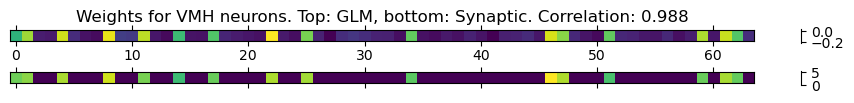

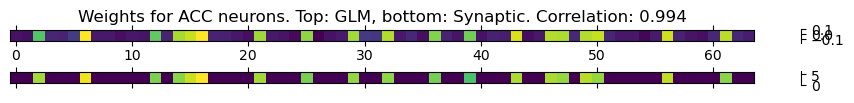

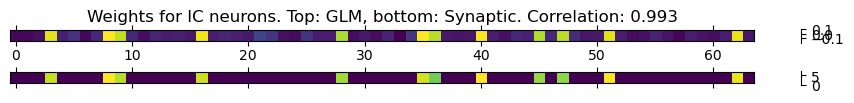

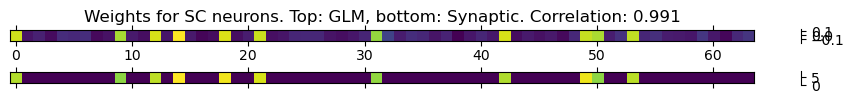

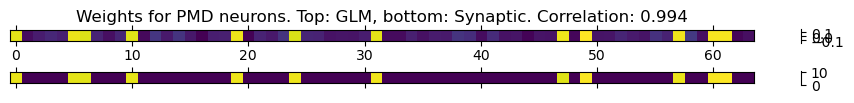

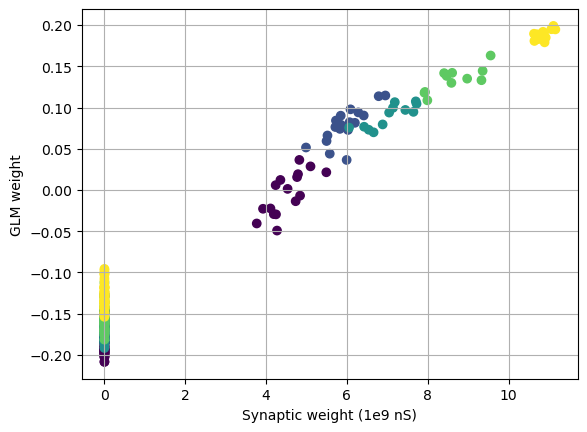

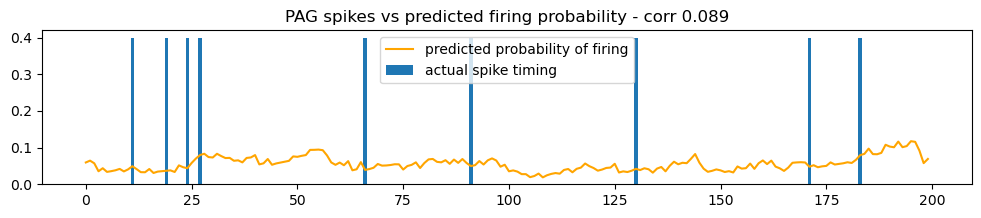

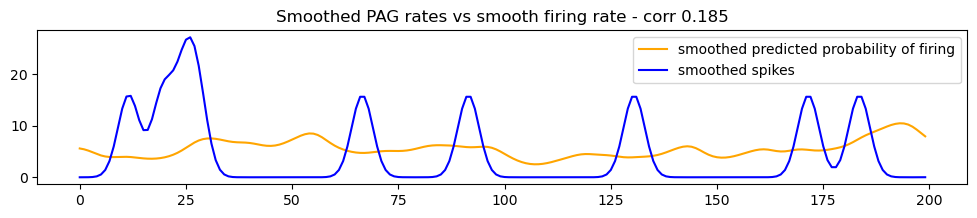

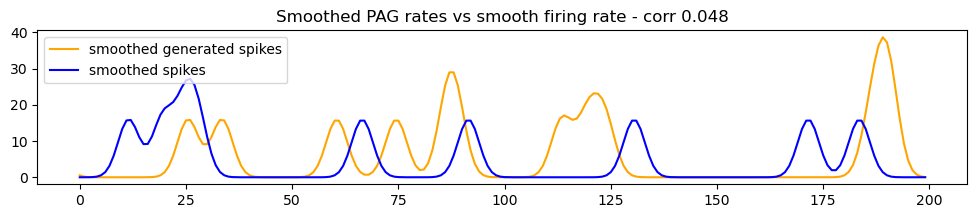

In [42]:
# comparison with actual connectivity
for m, brain_region in enumerate(brain_regions):
    
    corr = np.corrcoef(glm_w[..., glm.group_synapse_idx[m]], conns[m, :n_PAG_to_use, :])[0,1]
    f, axes = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(12,1))
    mat1 = axes[0].matshow(glm_w[..., glm.group_synapse_idx[m]])
    f.colorbar(mat1, shrink=0.4)
    axes[0].set_title(f'Weights for {brain_region} neurons. Top: GLM, bottom: Synaptic. Correlation: {str(corr)[:5]}')
    axes[0].set_yticks([])

    mat2 = axes[1].matshow(conns[m, :n_PAG_to_use, :])
    f.colorbar(mat2, shrink=0.4)
    axes[1].set_yticks([])
plt.show()

# scatter plot of all learned weights
plt.scatter(conns[:,:n_PAG_to_use,:].flatten(), glm_w, c=glm.synapse_origin_group)
plt.xlabel('Synaptic weight (1e9 nS)')
plt.ylabel('GLM weight')
plt.grid()
plt.show()

# test set prediction
with torch.no_grad():
    y_test_hat = glm(X_test.T).T # (1 PAG neuron * 100 secs)
    

plt.figure(figsize=(12,2))
plt.plot(y_test_hat.cpu()[0,_random_start:_random_start + _range], label='predicted probability of firing', color='orange')
plt.bar(np.arange(_range), y_test[0,_random_start:_random_start + _range]*0.4, label='actual spike timing')
plt.legend()
plt.title(f'PAG spikes vs predicted firing probability - corr {str(np.corrcoef(y_test, y_test_hat.cpu())[0,1])[:5]}')
plt.show()

generated_spikes = generate_bernoulli_spikes(y_test_hat)

smooth_y_test = rbf_rate_convolution_1d(y_test[0], sigma=0.025, dt=0.01)                                        # smooth test set spikes
smooth_y_test_hat = rbf_rate_convolution_1d(y_test_hat[0].cpu(), sigma=0.025, dt=0.01)                          # smooth predicted probabilities
smooth_y_test_hat_generated_spikes = rbf_rate_convolution_1d(generated_spikes[0].cpu(), sigma=0.025, dt=0.01)   # smooth generated spikes

plt.figure(figsize=(12,2))
plt.plot(smooth_y_test_hat[_random_start:_random_start + _range], label='smoothed predicted probability of firing', color='orange')
plt.plot(smooth_y_test[_random_start:_random_start + _range], label='smoothed spikes', color='blue')
plt.legend()
plt.title(f'Smoothed PAG rates vs smooth firing rate - corr {str(np.corrcoef(smooth_y_test_hat, smooth_y_test)[0,1])[:5]}')
plt.show()

plt.figure(figsize=(12,2))
plt.plot(smooth_y_test_hat_generated_spikes[_random_start:_random_start + _range], label='smoothed generated spikes', color='orange')
plt.plot(smooth_y_test[_random_start:_random_start + _range], label='smoothed spikes', color='blue')
plt.legend()
plt.title(f'Smoothed PAG rates vs smooth firing rate - corr {str(np.corrcoef(smooth_y_test_hat_generated_spikes, smooth_y_test)[0,1])[:5]}')
plt.show()

### Test 3 (condition 6): add Sparsity to weights

In [20]:
X_train.shape

(192, 800)

In [21]:
glm = BernoulliGLMPyTorch(
    group_names=brain_regions,
    n_neurons_per_group=n_neurons_per_group,
    link_fn='logistic',
    n_sessions=n_PAG_to_use,
    regs = ['weights_within_group',
            'weights_sparsity'],
    reg_params={'weights_within_group':100,
                'weights_sparsity':100
               },
    ).to(device)

# glm._load_state_dict(torch.load(f'{sim_data_path}sing_exp_reg100_spars100.pth'))

glm.fit(X_train.T, y_train.T, n_iter=30000, lr=1e-3, verbose=1, decay=0.9999)
glm.load_best_params()
torch.save(glm.state_dict(), f'{sim_data_path}sing_exp_reg100_spars100.pth')

2023-12-20 12:48:34.626 | DEBUG    | glm:fit:322 - Training GLM with PyTorch. Initial log like: 546.2603149414062, loss 1223.005859375, of which regs [5.699991, 671.04553, 0.0] respectively for ['weights_within_group', 'weights_sparsity', 'beta'].
2023-12-20 12:48:36.063 | DEBUG    | glm:fit:349 - Step 1500. Log like: 224.9984130859375, loss 227.20668029785156, of which regs [1.7107022e-09, 2.208261, 0.0] respectively for ['weights_within_group', 'weights_sparsity', 'beta'].
2023-12-20 12:48:37.324 | DEBUG    | glm:fit:349 - Step 3000. Log like: 125.2074203491211, loss 126.87567138671875, of which regs [3.4518133e-10, 1.6682508, 0.0] respectively for ['weights_within_group', 'weights_sparsity', 'beta'].
2023-12-20 12:48:38.470 | DEBUG    | glm:fit:349 - Step 4500. Log like: 86.11605072021484, loss 87.64372253417969, of which regs [3.77238e-10, 1.5276698, 0.0] respectively for ['weights_within_group', 'weights_sparsity', 'beta'].
2023-12-20 12:48:39.557 | DEBUG    | glm:fit:349 - Step 6

In [7]:
glm_w, glm_b = glm.best_weight.cpu().numpy(), glm.best_bias.cpu().numpy() # shape (1, 320), (1,)
print('Learned bias:', glm_b)
print('y-intercept:', 1/(1+np.exp(-glm_b)))

Learned bias: [-4.3694444]
y-intercept: [0.01250004]


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 38 and the array at index 1 has size 39

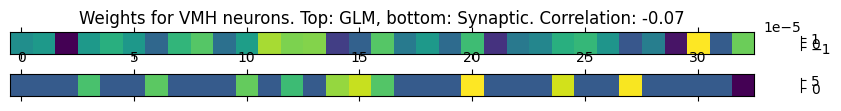

In [23]:
# comparison with actual connectivity
for m, brain_region in enumerate(brain_regions):
    
    corr = np.corrcoef(glm_w[..., glm.group_synapse_idx[m]], conns[m][:n_PAG_to_use, :])[0,1]
    f, axes = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(12,1))
    mat1 = axes[0].matshow(glm_w[..., glm.group_synapse_idx[m]])
    f.colorbar(mat1, shrink=0.4)
    axes[0].set_title(f'Weights for {brain_region} neurons. Top: GLM, bottom: Synaptic. Correlation: {str(corr)[:5]}')
    axes[0].set_yticks([])

    mat2 = axes[1].matshow(conns[m][:n_PAG_to_use, :])
    f.colorbar(mat2, shrink=0.4)
    axes[1].set_yticks([])
plt.show()

# scatter plot of all learned weights
plt.scatter(conns[:,:n_PAG_to_use,:].flatten(), glm_w, c=glm.synapse_origin_group)
plt.xlabel('Synaptic weight (1e9 nS)')
plt.ylabel('GLM weight')
plt.grid()
plt.show()

# test set prediction
with torch.no_grad():
    y_test_hat = glm(X_test.T).T # (1 PAG neuron * 100 secs)
    

plt.figure(figsize=(12,2))
plt.plot(y_test_hat.cpu()[0,_random_start:_random_start + _range], label='predicted probability of firing', color='orange')
plt.bar(np.arange(_range), y_test[0,_random_start:_random_start + _range]*0.4, label='actual spike timing')
plt.legend()
plt.title(f'PAG spikes vs predicted firing probability - corr {str(np.corrcoef(y_test, y_test_hat.cpu())[0,1])[:5]}')
plt.show()

generated_spikes = generate_bernoulli_spikes(y_test_hat)

smooth_y_test = rbf_rate_convolution_1d(y_test[0], sigma=0.025, dt=0.01)                                        # smooth test set spikes
smooth_y_test_hat = rbf_rate_convolution_1d(y_test_hat[0].cpu(), sigma=0.025, dt=0.01)                          # smooth predicted probabilities
smooth_y_test_hat_generated_spikes = rbf_rate_convolution_1d(generated_spikes[0].cpu(), sigma=0.025, dt=0.01)   # smooth generated spikes

plt.figure(figsize=(12,2))
plt.plot(smooth_y_test_hat[_random_start:_random_start + _range], label='smoothed predicted probability of firing', color='orange')
plt.plot(smooth_y_test[_random_start:_random_start + _range], label='smoothed spikes', color='blue')
plt.legend()
plt.title(f'Smoothed PAG rates vs smooth firing rate - corr {str(np.corrcoef(smooth_y_test_hat, smooth_y_test)[0,1])[:5]}')
plt.show()

plt.figure(figsize=(12,2))
plt.plot(smooth_y_test_hat_generated_spikes[_random_start:_random_start + _range], label='smoothed generated spikes', color='orange')
plt.plot(smooth_y_test[_random_start:_random_start + _range], label='smoothed spikes', color='blue')
plt.legend()
plt.title(f'Smoothed PAG rates vs smooth firing rate - corr {str(np.corrcoef(smooth_y_test_hat_generated_spikes, smooth_y_test)[0,1])[:5]}')
plt.show()

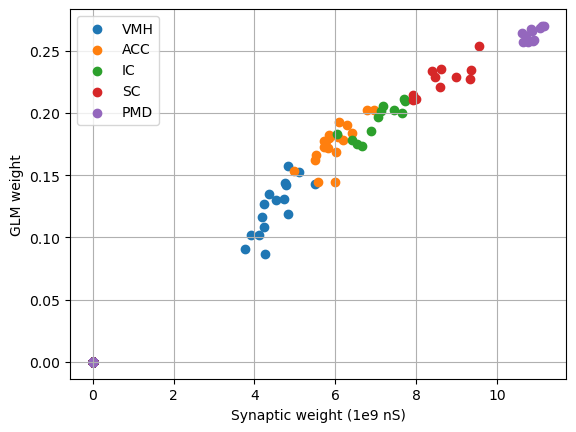

In [27]:
cdict = {i:j for i,j in enumerate(brain_regions)}
for g in np.unique(glm.synapse_origin_group):
    ix = np.where(glm.synapse_origin_group == g)
    plt.scatter(conns[:,:n_PAG_to_use,:].flatten()[ix], glm_w[0,ix], c=f'C{str(g)}', label=cdict[g])

plt.xlabel('Synaptic weight (1e9 nS)')
plt.ylabel('GLM weight')
plt.legend()
plt.grid()
plt.show()

In [21]:
np.unique(glm.synapse_origin_group)

array([0, 1, 2, 3, 4])

In [15]:
conns[:,:n_PAG_to_use,:].flatten().shape

(320,)

In [15]:
glm_w

array([[ 8.65884796e-02,  1.29778162e-01,  6.89301260e-06,
         3.85474914e-06,  1.41832352e-01,  3.30967232e-05,
        -1.53126985e-05, -7.03545447e-06,  1.52905419e-01,
         4.80628023e-06,  3.28501915e-06,  1.34745434e-01,
         5.32996683e-06,  4.14219812e-06,  9.08747911e-02,
         1.03333405e-05,  1.70304475e-06,  1.08016506e-01,
        -4.12731970e-06, -2.56006729e-06, -1.10057472e-05,
         2.35859152e-05,  1.57016620e-01,  1.24573762e-05,
        -7.10532163e-07,  1.30682200e-01,  1.42663691e-06,
        -1.60277777e-05,  1.68664963e-06, -2.38865846e-06,
         4.02256228e-06,  7.68109840e-06, -1.37792938e-06,
        -1.62224860e-05,  1.01856373e-01, -2.19794720e-06,
         5.56784244e-06,  6.63328183e-06,  3.29858744e-06,
         5.21773563e-06, -5.65576738e-06,  2.62844310e-06,
         2.96030657e-06,  4.11615201e-06,  1.54429028e-06,
         1.14676386e-05,  1.43067062e-01,  1.18973903e-01,
         6.23298502e-06, -2.88440447e-06, -2.12033992e-0

### Test 4: History filter alone

In [14]:
history = 10
from glm import BernoulliGLMwHistoryPyTorch
glm = BernoulliGLMwHistoryPyTorch(
    group_names=brain_regions,
    n_neurons_per_group=np.array([64, 64, 64, 64, 64]),
    link_fn='logistic',
    n_sessions=n_PAG_to_use,
    regs = ['weights_within_group'],
    reg_params={'weights_within_group':np.array([100,100,100,100,100])
               },
    history=history,
    ).to(device)

glm._load_state_dict(torch.load(f'{sim_data_path}sing_exp_reg100_history{history}.pth'))

glm.fit(X_train.T, y_train.T, n_iter=40000, lr=1e-3, verbose=1, decay=0.99995)
glm.load_best_params()
torch.save(glm.state_dict(), f'{sim_data_path}sing_exp_reg100_history{history}.pth')

2023-12-14 16:54:59.519 | DEBUG    | glm:fit:316 - Training GLM with PyTorch. Initial log like: 43019.7890625, loss 43871.4765625, of which regs [851.68823, 0.0, 0.0] respectively for ['weights_within_group', 'weights_sparsity', 'beta'].
2023-12-14 16:55:35.506 | DEBUG    | glm:fit:343 - Step 2000. Log like: 42859.0625, loss 43693.08203125, of which regs [834.01825, 0.0, 0.0] respectively for ['weights_within_group', 'weights_sparsity', 'beta'].
2023-12-14 16:56:09.620 | DEBUG    | glm:fit:343 - Step 4000. Log like: 42720.484375, loss 43539.88671875, of which regs [819.4027, 0.0, 0.0] respectively for ['weights_within_group', 'weights_sparsity', 'beta'].
2023-12-14 16:56:43.356 | DEBUG    | glm:fit:343 - Step 6000. Log like: 42602.2734375, loss 43408.8671875, of which regs [806.594, 0.0, 0.0] respectively for ['weights_within_group', 'weights_sparsity', 'beta'].
2023-12-14 16:57:17.755 | DEBUG    | glm:fit:343 - Step 8000. Log like: 42500.06640625, loss 43295.4140625, of which regs [79

In [12]:
glm_w, glm_b = glm.best_weight.cpu().numpy(), glm.best_bias.cpu().numpy() # shape (1, 320), (1,)
print('Learned bias:', glm_b)
print('y-intercept:', 1/(1+np.exp(-glm_b)))

Learned bias: [-5.395081]
y-intercept: [0.00451834]


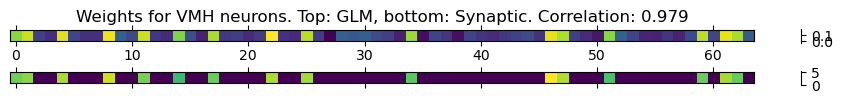

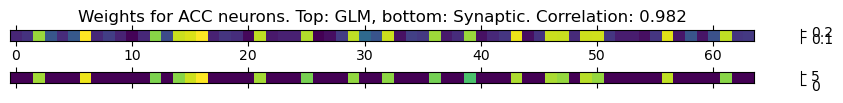

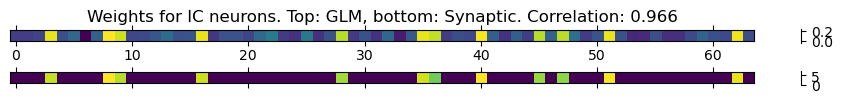

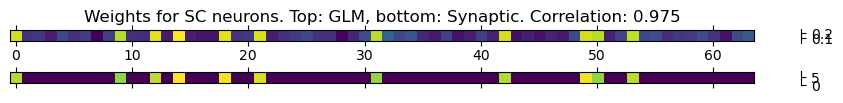

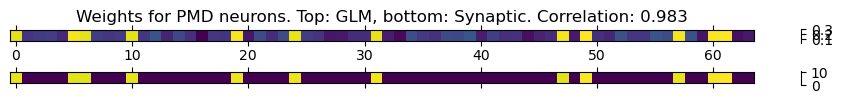

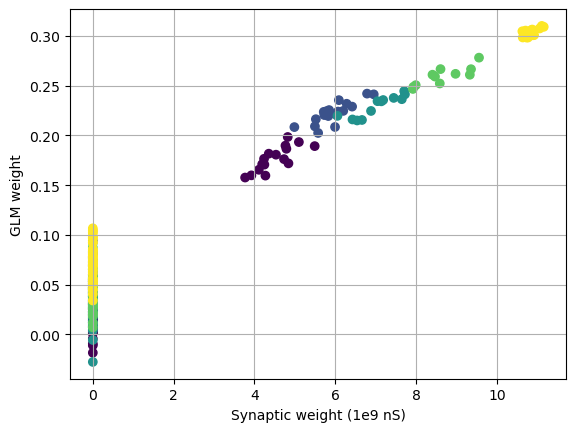

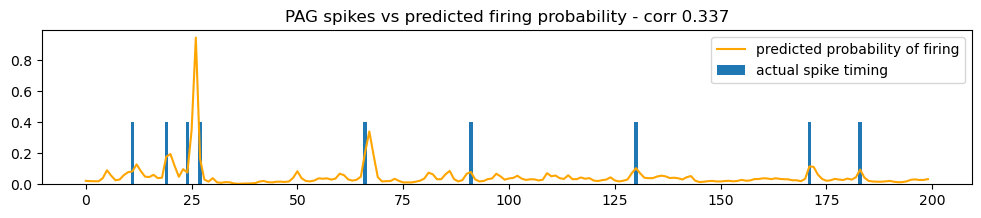

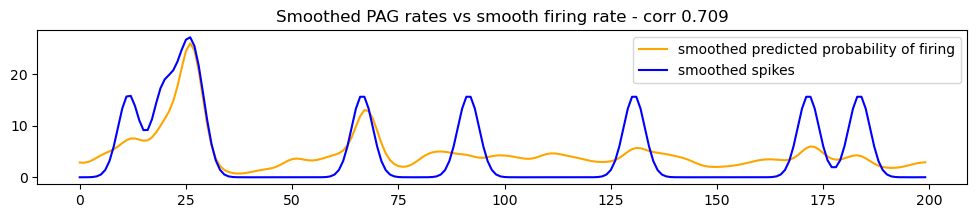

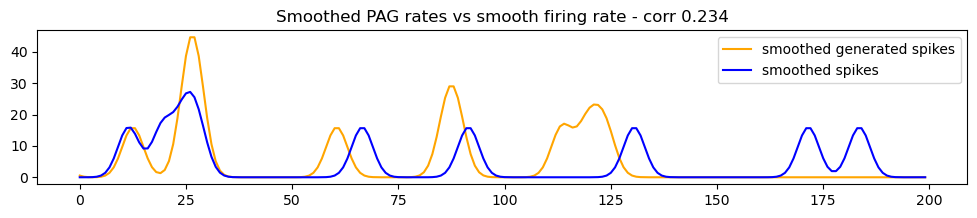

In [13]:
# comparison with actual connectivity
for m, brain_region in enumerate(brain_regions):
    
    corr = np.corrcoef(glm_w[..., glm.group_synapse_idx[m]], conns[m, :n_PAG_to_use, :])[0,1]
    f, axes = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(12,1))
    mat1 = axes[0].matshow(glm_w[..., glm.group_synapse_idx[m]])
    f.colorbar(mat1, shrink=0.4)
    axes[0].set_title(f'Weights for {brain_region} neurons. Top: GLM, bottom: Synaptic. Correlation: {str(corr)[:5]}')
    axes[0].set_yticks([])

    mat2 = axes[1].matshow(conns[m, :n_PAG_to_use, :])
    f.colorbar(mat2, shrink=0.4)
    axes[1].set_yticks([])
plt.show()

# scatter plot of all learned weights
plt.scatter(conns[:,:n_PAG_to_use,:].flatten(), glm_w, c=glm.synapse_origin_group)
plt.xlabel('Synaptic weight (1e9 nS)')
plt.ylabel('GLM weight')
plt.grid()
plt.show()

# test set prediction
with torch.no_grad():
    y_test_hat = glm(X_test.T).T # (1 PAG neuron * 100 secs)
    

plt.figure(figsize=(12,2))
plt.plot(y_test_hat.cpu()[0,_random_start:_random_start + _range], label='predicted probability of firing', color='orange')
plt.bar(np.arange(_range), y_test[0,_random_start:_random_start + _range]*0.4, label='actual spike timing')
plt.legend()
plt.title(f'PAG spikes vs predicted firing probability - corr {str(np.corrcoef(y_test, y_test_hat.cpu())[0,1])[:5]}')
plt.show()

generated_spikes = generate_bernoulli_spikes(y_test_hat)

smooth_y_test = rbf_rate_convolution_1d(y_test[0], sigma=0.025, dt=0.01)                                        # smooth test set spikes
smooth_y_test_hat = rbf_rate_convolution_1d(y_test_hat[0].cpu(), sigma=0.025, dt=0.01)                          # smooth predicted probabilities
smooth_y_test_hat_generated_spikes = rbf_rate_convolution_1d(generated_spikes[0].cpu(), sigma=0.025, dt=0.01)   # smooth generated spikes

plt.figure(figsize=(12,2))
plt.plot(smooth_y_test_hat[_random_start:_random_start + _range], label='smoothed predicted probability of firing', color='orange')
plt.plot(smooth_y_test[_random_start:_random_start + _range], label='smoothed spikes', color='blue')
plt.legend()
plt.title(f'Smoothed PAG rates vs smooth firing rate - corr {str(np.corrcoef(smooth_y_test_hat, smooth_y_test)[0,1])[:5]}')
plt.show()

plt.figure(figsize=(12,2))
plt.plot(smooth_y_test_hat_generated_spikes[_random_start:_random_start + _range], label='smoothed generated spikes', color='orange')
plt.plot(smooth_y_test[_random_start:_random_start + _range], label='smoothed spikes', color='blue')
plt.legend()
plt.title(f'Smoothed PAG rates vs smooth firing rate - corr {str(np.corrcoef(smooth_y_test_hat_generated_spikes, smooth_y_test)[0,1])[:5]}')
plt.show()

### Test 5: History filter + sparsity

In [30]:
history = 10
from glm import BernoulliGLMwHistoryPyTorch
glm = BernoulliGLMwHistoryPyTorch(
    group_names=brain_regions,
    n_neurons_per_group=np.array([64, 64, 64, 64, 64]),
    link_fn='logistic',
    n_sessions=n_PAG_to_use,
    regs = ['weights_within_group',
            'weights_sparsity'],
    reg_params={'weights_within_group':100,
                'weights_sparsity':100
               },
    history=history,
    ).to(device)

glm._load_state_dict(torch.load(f'{sim_data_path}sing_exp_reg100_sparse100_history{history}.pth'))

# glm.fit(X_train.T, y_train.T, n_iter=50000, lr=1e-3, verbose=1, decay=0.99995)
# glm.load_best_params()
# torch.save(glm.state_dict(), f'{sim_data_path}sing_exp_reg100_sparse100_history{history}.pth')

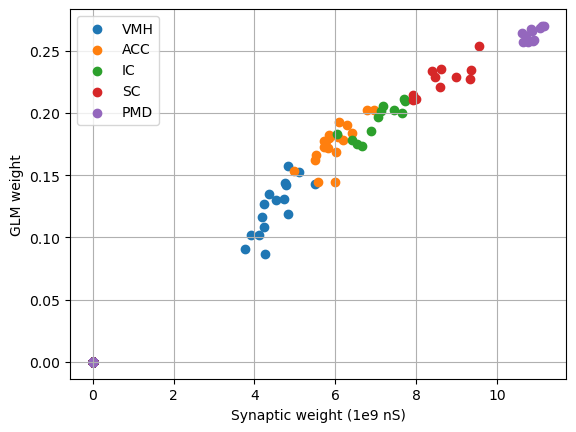

In [31]:
cdict = {i:j for i,j in enumerate(brain_regions)}
for g in np.unique(glm.synapse_origin_group):
    ix = np.where(glm.synapse_origin_group == g)
    plt.scatter(conns[:,:n_PAG_to_use,:].flatten()[ix], glm_w[0,ix], c=f'C{str(g)}', label=cdict[g])

plt.xlabel('Synaptic weight (1e9 nS)')
plt.ylabel('GLM weight')
plt.legend()
plt.grid()
plt.show()

In [9]:
glm_w, glm_b = glm.best_weight.cpu().numpy(), glm.best_bias.cpu().numpy() # shape (1, 320), (1,)
print('Learned bias:', glm_b)
print('y-intercept:', 1/(1+np.exp(-glm_b)))

Learned bias: [-4.4602723]
y-intercept: [0.01142713]


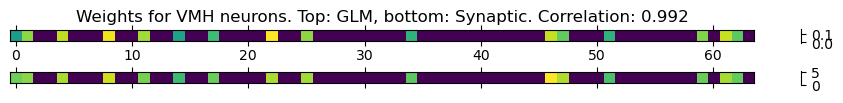

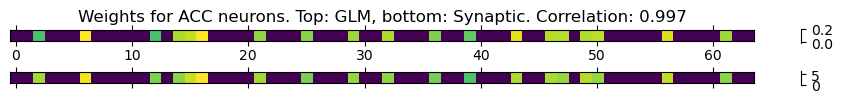

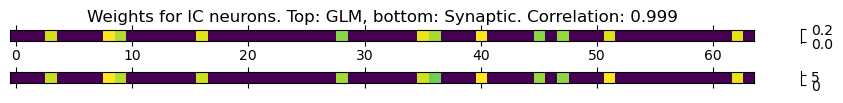

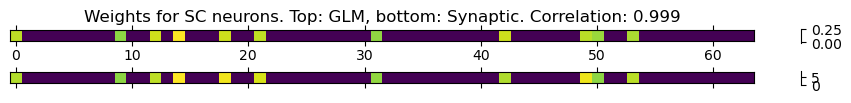

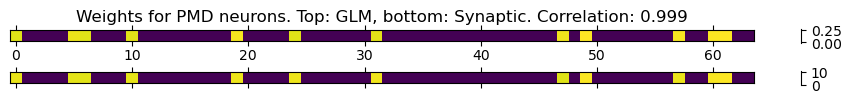

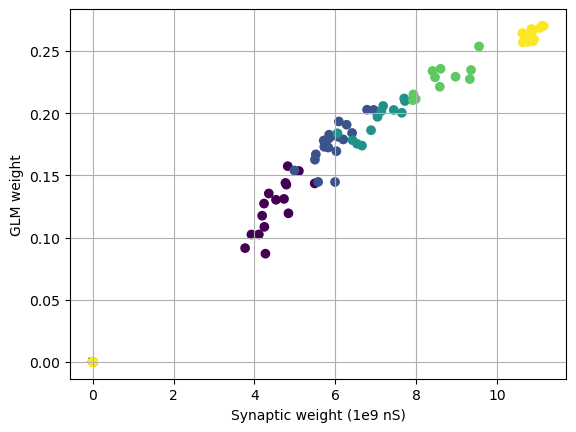

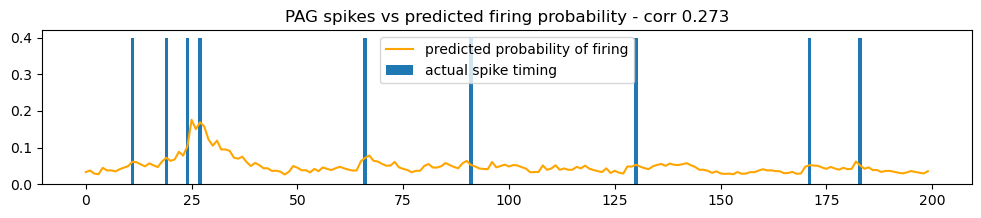

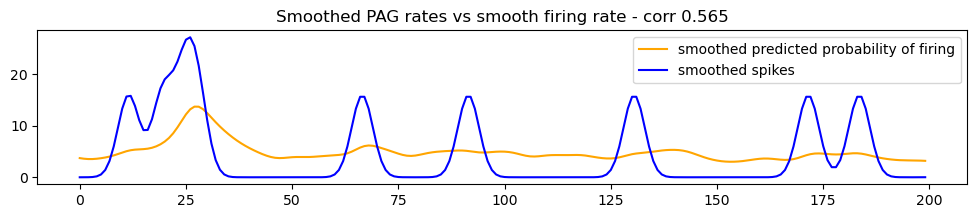

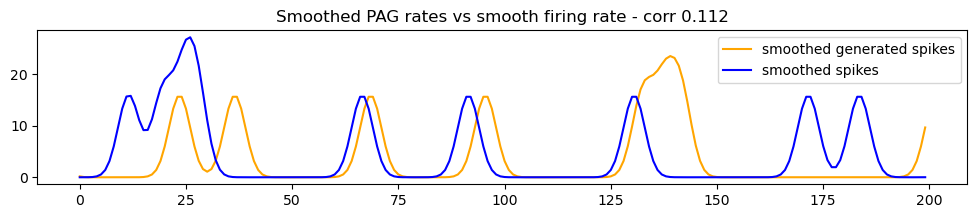

In [10]:
# comparison with actual connectivity
for m, brain_region in enumerate(brain_regions):
    
    corr = np.corrcoef(glm_w[..., glm.group_synapse_idx[m]], conns[m, :n_PAG_to_use, :])[0,1]
    f, axes = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(12,1))
    mat1 = axes[0].matshow(glm_w[..., glm.group_synapse_idx[m]])
    f.colorbar(mat1, shrink=0.4)
    axes[0].set_title(f'Weights for {brain_region} neurons. Top: GLM, bottom: Synaptic. Correlation: {str(corr)[:5]}')
    axes[0].set_yticks([])

    mat2 = axes[1].matshow(conns[m, :n_PAG_to_use, :])
    f.colorbar(mat2, shrink=0.4)
    axes[1].set_yticks([])
plt.show()

# scatter plot of all learned weights
plt.scatter(conns[:,:n_PAG_to_use,:].flatten(), glm_w, c=glm.synapse_origin_group)
plt.xlabel('Synaptic weight (1e9 nS)')
plt.ylabel('GLM weight')
plt.grid()
plt.show()

# test set prediction
with torch.no_grad():
    y_test_hat = glm(X_test.T).T # (1 PAG neuron * 100 secs)
    

plt.figure(figsize=(12,2))
plt.plot(y_test_hat.cpu()[0,_random_start:_random_start + _range], label='predicted probability of firing', color='orange')
plt.bar(np.arange(_range), y_test[0,_random_start:_random_start + _range]*0.4, label='actual spike timing')
plt.legend()
plt.title(f'PAG spikes vs predicted firing probability - corr {str(np.corrcoef(y_test, y_test_hat.cpu())[0,1])[:5]}')
plt.show()

generated_spikes = generate_bernoulli_spikes(y_test_hat)

smooth_y_test = rbf_rate_convolution_1d(y_test[0], sigma=0.025, dt=0.01)                                        # smooth test set spikes
smooth_y_test_hat = rbf_rate_convolution_1d(y_test_hat[0].cpu(), sigma=0.025, dt=0.01)                          # smooth predicted probabilities
smooth_y_test_hat_generated_spikes = rbf_rate_convolution_1d(generated_spikes[0].cpu(), sigma=0.025, dt=0.01)   # smooth generated spikes

plt.figure(figsize=(12,2))
plt.plot(smooth_y_test_hat[_random_start:_random_start + _range], label='smoothed predicted probability of firing', color='orange')
plt.plot(smooth_y_test[_random_start:_random_start + _range], label='smoothed spikes', color='blue')
plt.legend()
plt.title(f'Smoothed PAG rates vs smooth firing rate - corr {str(np.corrcoef(smooth_y_test_hat, smooth_y_test)[0,1])[:5]}')
plt.show()

plt.figure(figsize=(12,2))
plt.plot(smooth_y_test_hat_generated_spikes[_random_start:_random_start + _range], label='smoothed generated spikes', color='orange')
plt.plot(smooth_y_test[_random_start:_random_start + _range], label='smoothed spikes', color='blue')
plt.legend()
plt.title(f'Smoothed PAG rates vs smooth firing rate - corr {str(np.corrcoef(smooth_y_test_hat_generated_spikes, smooth_y_test)[0,1])[:5]}')
plt.show()

(array([8., 0., 0., 1., 0., 0., 0., 0., 0., 1.]),
 array([-0.09523303, -0.06609508, -0.03695714, -0.00781919,  0.02131875,
         0.0504567 ,  0.07959464,  0.10873259,  0.13787054,  0.16700849,
         0.19614643]),
 <BarContainer object of 10 artists>)

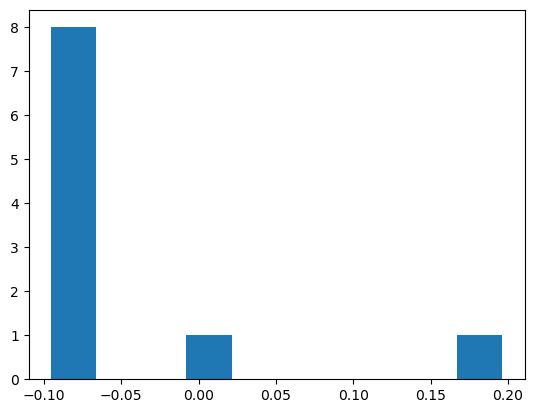

In [11]:
plt.hist(glm.history_filters.weight.data.cpu())

(array([20., 52., 72., 72., 29., 14., 17., 11., 20., 13.]),
 array([-0.19932969, -0.12045809, -0.0415865 ,  0.0372851 ,  0.1161567 ,
         0.19502831,  0.27389988,  0.35277149,  0.4316431 ,  0.51051468,
         0.58938628]),
 <BarContainer object of 10 artists>)

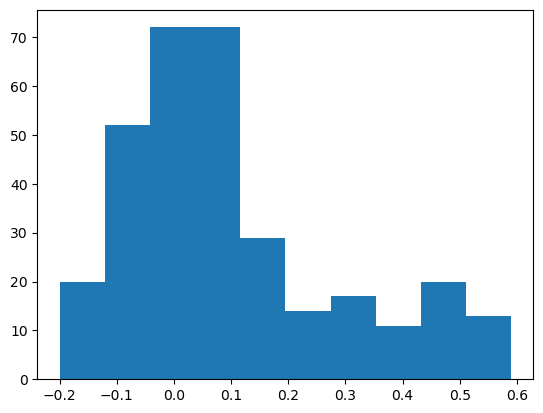

In [46]:
plt.hist(glm_w.T)

### Single PAG with the multi cell filter

In [5]:
from glm import BernoulliGLMwHistoryMultiSessionPyTorch
history = 10
glm = BernoulliGLMwHistoryMultiSessionPyTorch(
    group_names=brain_regions,
    n_neurons_per_group=np.array([64, 64, 64, 64, 64]),
    link_fn='logistic',
    n_sessions=n_PAG_to_use,
    regs = ['weights_within_group',
            'weights_sparsity'],
    reg_params={'weights_within_group':100,
                'weights_sparsity':100
               },
    history=history,
    ).to(device)

#glm._load_state_dict(torch.load(f'{sim_data_path}sing_exp_reg100_sparse100_history{history}.pth'))

glm.fit(X_train.T, y_train.T, n_iter=50000, lr=1e-3, verbose=1, decay=0.99995)
glm.load_best_params()


2023-12-18 03:23:11.045 | DEBUG    | glm:fit:322 - Training GLM with PyTorch. Initial log like: 282247.90625, loss 283100.5, of which regs [5.355341, 847.231, 0.0] respectively for ['weights_within_group', 'weights_sparsity', 'beta'].
2023-12-18 03:24:12.665 | DEBUG    | glm:fit:349 - Step 2500. Log like: 53703.0390625, loss 57342.69921875, of which regs [324.81564, 3314.846, 0.0] respectively for ['weights_within_group', 'weights_sparsity', 'beta'].
2023-12-18 03:25:13.363 | DEBUG    | glm:fit:349 - Step 5000. Log like: 52508.28125, loss 55598.0234375, of which regs [336.82172, 2752.9187, 0.0] respectively for ['weights_within_group', 'weights_sparsity', 'beta'].
2023-12-18 03:26:12.188 | DEBUG    | glm:fit:349 - Step 7500. Log like: 50892.953125, loss 53009.01953125, of which regs [407.61, 1708.4567, 0.0] respectively for ['weights_within_group', 'weights_sparsity', 'beta'].
2023-12-18 03:27:11.125 | DEBUG    | glm:fit:349 - Step 10000. Log like: 48673.24609375, loss 50782.2265625, o

In [6]:
glm_w, glm_b = glm.best_weight.cpu().numpy(), glm.best_bias.cpu().numpy() # shape (1, 320), (1,)
print('Learned bias:', glm_b)
print('y-intercept:', 1/(1+np.exp(-glm_b)))

Learned bias: [-3.8244498]
y-intercept: [0.02136406]


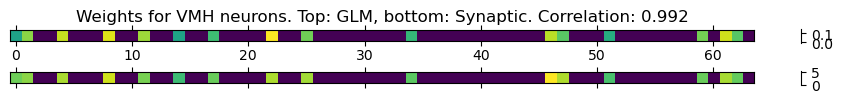

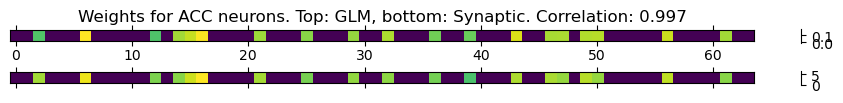

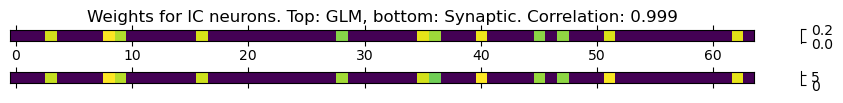

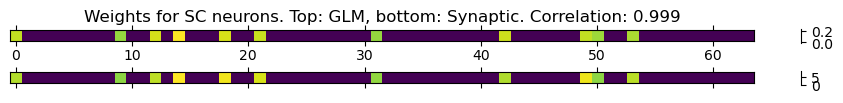

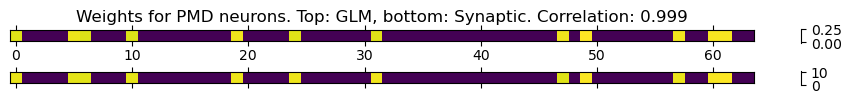

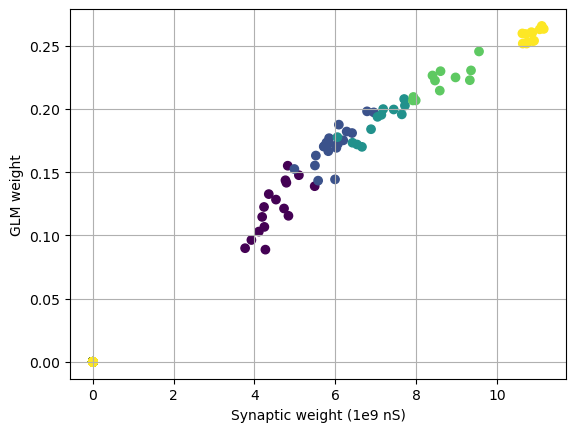

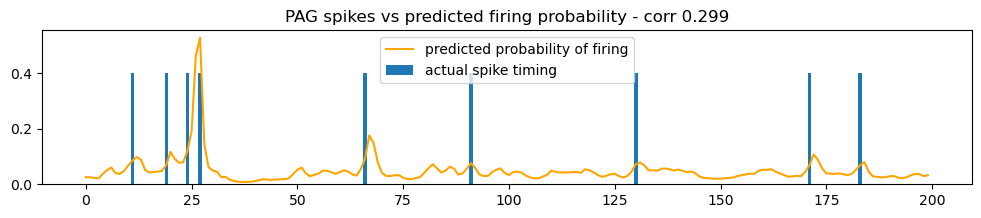

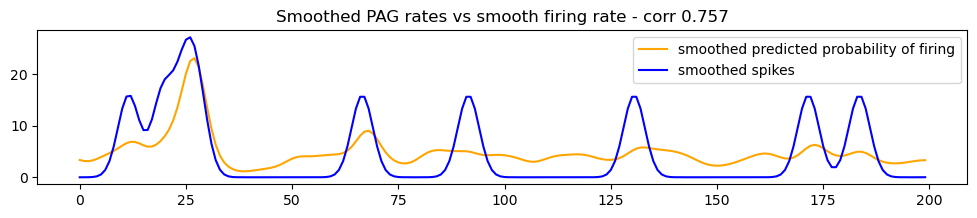

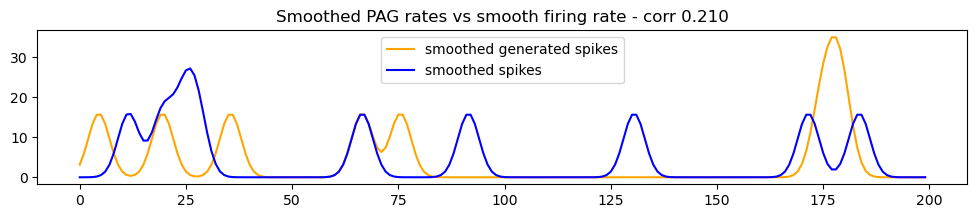

In [7]:
# comparison with actual connectivity
for m, brain_region in enumerate(brain_regions):
    
    corr = np.corrcoef(glm_w[..., glm.group_synapse_idx[m]], conns[m, :n_PAG_to_use, :])[0,1]
    f, axes = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(12,1))
    mat1 = axes[0].matshow(glm_w[..., glm.group_synapse_idx[m]])
    f.colorbar(mat1, shrink=0.4)
    axes[0].set_title(f'Weights for {brain_region} neurons. Top: GLM, bottom: Synaptic. Correlation: {str(corr)[:5]}')
    axes[0].set_yticks([])

    mat2 = axes[1].matshow(conns[m, :n_PAG_to_use, :])
    f.colorbar(mat2, shrink=0.4)
    axes[1].set_yticks([])
plt.show()

# scatter plot of all learned weights
plt.scatter(conns[:,:n_PAG_to_use,:].flatten(), glm_w, c=glm.synapse_origin_group)
plt.xlabel('Synaptic weight (1e9 nS)')
plt.ylabel('GLM weight')
plt.grid()
plt.show()

# test set prediction
with torch.no_grad():
    y_test_hat = glm(X_test.T).T # (1 PAG neuron * 100 secs)
    

plt.figure(figsize=(12,2))
plt.plot(y_test_hat.cpu()[0,_random_start:_random_start + _range], label='predicted probability of firing', color='orange')
plt.bar(np.arange(_range), y_test[0,_random_start:_random_start + _range]*0.4, label='actual spike timing')
plt.legend()
plt.title(f'PAG spikes vs predicted firing probability - corr {str(np.corrcoef(y_test, y_test_hat.cpu())[0,1])[:5]}')
plt.show()

generated_spikes = generate_bernoulli_spikes(y_test_hat)

smooth_y_test = rbf_rate_convolution_1d(y_test[0], sigma=0.025, dt=0.01)                                        # smooth test set spikes
smooth_y_test_hat = rbf_rate_convolution_1d(y_test_hat[0].cpu(), sigma=0.025, dt=0.01)                          # smooth predicted probabilities
smooth_y_test_hat_generated_spikes = rbf_rate_convolution_1d(generated_spikes[0].cpu(), sigma=0.025, dt=0.01)   # smooth generated spikes

plt.figure(figsize=(12,2))
plt.plot(smooth_y_test_hat[_random_start:_random_start + _range], label='smoothed predicted probability of firing', color='orange')
plt.plot(smooth_y_test[_random_start:_random_start + _range], label='smoothed spikes', color='blue')
plt.legend()
plt.title(f'Smoothed PAG rates vs smooth firing rate - corr {str(np.corrcoef(smooth_y_test_hat, smooth_y_test)[0,1])[:5]}')
plt.show()

plt.figure(figsize=(12,2))
plt.plot(smooth_y_test_hat_generated_spikes[_random_start:_random_start + _range], label='smoothed generated spikes', color='orange')
plt.plot(smooth_y_test[_random_start:_random_start + _range], label='smoothed spikes', color='blue')
plt.legend()
plt.title(f'Smoothed PAG rates vs smooth firing rate - corr {str(np.corrcoef(smooth_y_test_hat_generated_spikes, smooth_y_test)[0,1])[:5]}')
plt.show()

In [8]:
glm.get_history_filter_weights()

tensor([[ 11.9348,   9.4041, -10.0407,  -8.8736,  -1.8587,  -1.3270,  -3.0770,
          -0.2041,  -1.5568,  -3.1696]], device='cuda:0')

## MultiPAG case

In [3]:
n_PAG_to_use = 8

pag_df = extract_sim_as_df(sim_data_path, 'PAG')
pag_timings = extract_timings(pag_df, 'PAG')
pag_binned_spikes = bin_spikes(pag_timings, start_time=0, end_time=_total_length, bin_size=bin_size)[:n_PAG_to_use]
print(f'Average PAG firing rate: {np.sum(pag_binned_spikes) / pag_binned_spikes.shape[0] / _total_length} Hz.')

2023-12-18 09:25:04.934 | DEBUG    | utils:bin_spikes:63 - Created spike bin matrix with 8 neurons and 600000 bins. Total number of spikes: 224761.0


Average PAG firing rate: 46.825208333333336 Hz.


In [4]:
# construct input and output matrices
train_start = 0
train_end = 300
test_start = 300
test_end = 400
# for pag_stim_w_stimuli, external pulses are delivered from 40 mins to 60 mins, 10 secs each, lasting 1 sec
train_bins = int((train_end - train_start) / bin_size)
test_bins = int((test_end - test_start) / bin_size)

X_train, X_test = np.zeros((n_input_neurons*n_PAG_to_use, n_PAG_to_use * train_bins)), np.zeros((n_input_neurons*n_PAG_to_use, n_PAG_to_use * test_bins))
y_train, y_test = np.zeros((1, train_bins * n_PAG_to_use)), np.zeros((1, test_bins * n_PAG_to_use))

print(X_train.shape)
for n in range(n_PAG_to_use):
    X_train[n_input_neurons*n:n_input_neurons*(n+1), n * train_bins: (n+1) * train_bins] = presyn_smooth[:, int(train_start/bin_size):int(train_end/bin_size)] # chunks of n_neurons * train_set_bin_size
    X_test[n_input_neurons*n:n_input_neurons*(n+1), n * test_bins :(n+1) * test_bins] = presyn_smooth[:, int(test_start/bin_size):int(test_end/bin_size)]
    
    y_train[:, n * train_bins: (n+1)* train_bins] = pag_binned_spikes[n, int(train_start/bin_size): int(train_end/bin_size)]
    y_test[:, n * test_bins: (n+1)* test_bins] = pag_binned_spikes[n, int(test_start/bin_size): int(test_end/bin_size)]
assert X_train.shape[1] == y_train.shape[1]
assert X_test.shape[1] == y_test.shape[1]

print('Number of PAG spikes in the training set: ', np.sum(y_train))
print('Number of PAG spikes in the test set: ', np.sum(y_test))

(2560, 2400000)
Number of PAG spikes in the training set:  112056.0
Number of PAG spikes in the test set:  37146.0


### Test 6 :History Filter on 8 PAG cells

In [8]:
from glm import BernoulliGLMwHistoryMultiSessionPyTorch
history = 5
glm = BernoulliGLMwHistoryMultiSessionPyTorch(
    group_names=brain_regions,
    n_neurons_per_group=np.array([64, 64, 64, 64, 64]),
    link_fn='logistic',
    n_sessions=n_PAG_to_use,
    regs = ['weights_within_group',
            'weights_sparsity'],
    reg_params={'weights_within_group':100,
                'weights_sparsity':100
               },
    history=history,
    ).to(device)

glm._load_state_dict(torch.load(f'{sim_data_path}mult_exp_reg100_hist5.pth'))

glm.fit(X_train.T, y_train.T, n_iter=2500, lr=1e-3, verbose=1, decay=1)
glm.load_best_params()

2023-12-18 09:49:24.695 | DEBUG    | glm:fit:322 - Training GLM with PyTorch. Initial log like: 471550.15625, loss 493717.875, of which regs [421.4389, 21746.287, 0.0] respectively for ['weights_within_group', 'weights_sparsity', 'beta'].


KeyboardInterrupt: 

In [6]:
torch.save(glm.state_dict(), f'{sim_data_path}mult_exp_reg100_hist5.pth')

Learned bias: [-0.21357241]
y-intercept: [0.44680893]


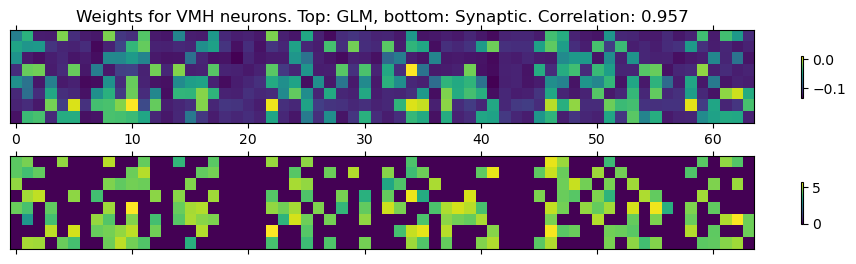

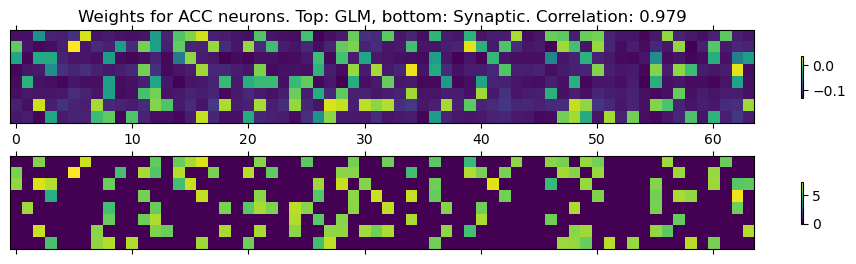

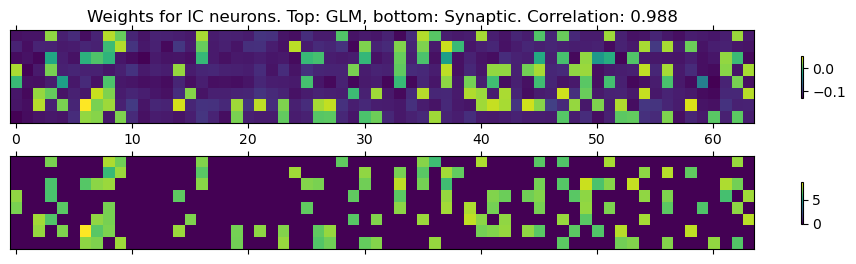

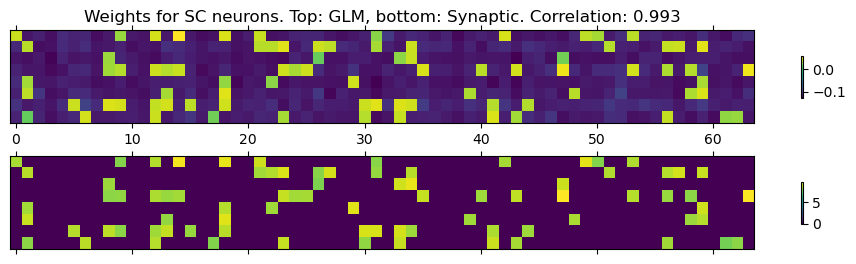

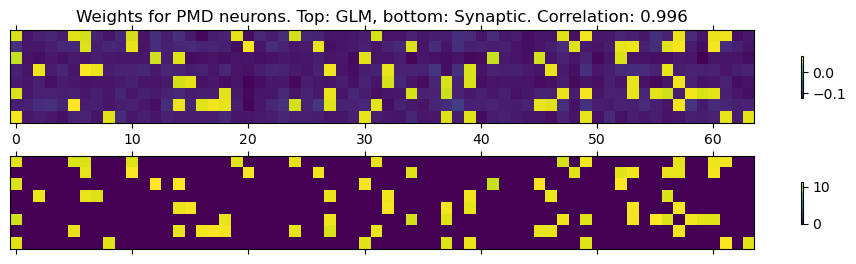

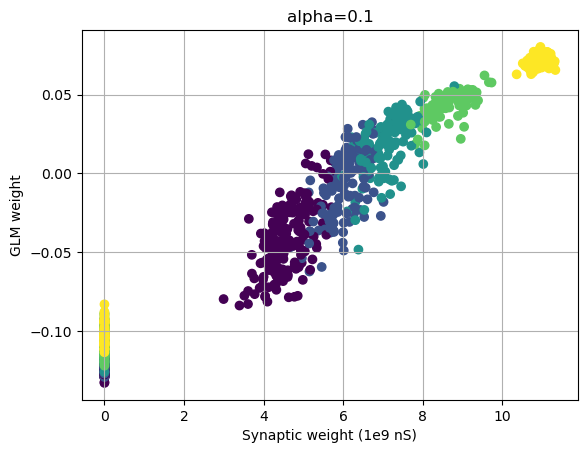

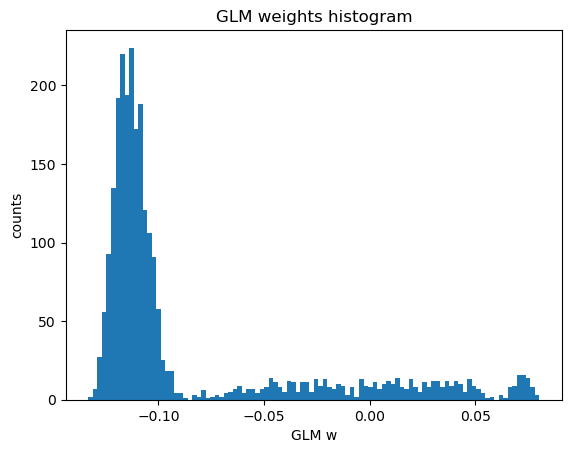

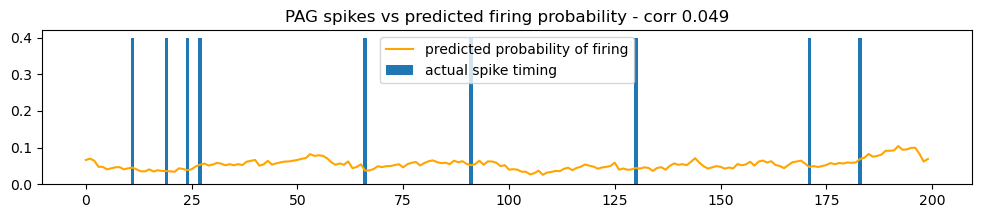

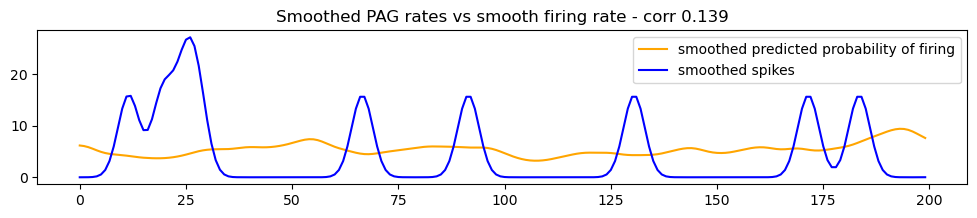

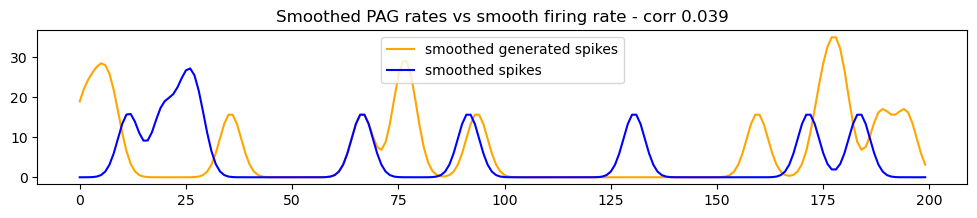

In [13]:
glm_w, glm_b = glm.best_weight.cpu().numpy(), glm.best_bias.cpu().numpy() # shape (1, 320), (1,)
print('Learned bias:', glm_b)
print('y-intercept:', 1/(1+np.exp(-glm_b)))


# comparison with actual connectivity
for m, brain_region in enumerate(brain_regions):
    
    corr = np.corrcoef(glm_w[..., glm.group_neuron_idx[m]], conns[m, :n_PAG_to_use, :].flatten())[0,1]
    
    f, axes = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(12,3))
    mat1 = axes[0].matshow(glm_w[..., glm.group_neuron_idx[m]].reshape(n_PAG_to_use, -1))
    f.colorbar(mat1, shrink=0.4)
    axes[0].set_title(f'Weights for {brain_region} neurons. Top: GLM, bottom: Synaptic. Correlation: {str(corr)[:5]}')
    axes[0].set_yticks([])

    mat2 = axes[1].matshow(conns[m, :n_PAG_to_use, :])
    f.colorbar(mat2, shrink=0.4)
    axes[1].set_yticks([])
plt.show()

plt.scatter(conns[:,:n_PAG_to_use,:].transpose(1,0,2).flatten(), glm_w, c=glm.neuron_group_idx)
plt.xlabel('Synaptic weight (1e9 nS)')
plt.ylabel('GLM weight')
plt.grid()
plt.title('alpha=0.1')
plt.show()

plt.hist(glm_w[0], bins=100);
plt.xlabel('GLM w')
plt.ylabel('counts')
plt.title('GLM weights histogram')
plt.show()

# test set prediction
with torch.no_grad():
    y_test_hat = glm(X_test.T).T # (1 PAG neuron * 100 secs)
    
# _range = 200 #ms
# _random_start = np.random.randint(y_test.shape[1]-_range)

plt.figure(figsize=(12,2))
plt.plot(y_test_hat.cpu()[0,_random_start:_random_start + _range], label='predicted probability of firing', color='orange')
plt.bar(np.arange(_range), y_test[0,_random_start:_random_start + _range]*0.4, label='actual spike timing')
plt.legend()
plt.title(f'PAG spikes vs predicted firing probability - corr {str(np.corrcoef(y_test, y_test_hat.cpu())[0,1])[:5]}')
plt.show()



generated_spikes = generate_bernoulli_spikes(y_test_hat)

smooth_y_test = rbf_rate_convolution_1d(y_test[0], sigma=0.025, dt=0.01)                                        # smooth test set spikes
smooth_y_test_hat = rbf_rate_convolution_1d(y_test_hat[0].cpu(), sigma=0.025, dt=0.01)                          # smooth predicted probabilities
smooth_y_test_hat_generated_spikes = rbf_rate_convolution_1d(generated_spikes[0].cpu(), sigma=0.025, dt=0.01)   # smooth generated spikes

plt.figure(figsize=(12,2))
plt.plot(smooth_y_test_hat[_random_start:_random_start + _range], label='smoothed predicted probability of firing', color='orange')
plt.plot(smooth_y_test[_random_start:_random_start + _range], label='smoothed spikes', color='blue')
plt.legend()
plt.title(f'Smoothed PAG rates vs smooth firing rate - corr {str(np.corrcoef(smooth_y_test_hat, smooth_y_test)[0,1])[:5]}')
plt.show()

plt.figure(figsize=(12,2))
plt.plot(smooth_y_test_hat_generated_spikes[_random_start:_random_start + _range], label='smoothed generated spikes', color='orange')
plt.plot(smooth_y_test[_random_start:_random_start + _range], label='smoothed spikes', color='blue')
plt.legend()
plt.title(f'Smoothed PAG rates vs smooth firing rate - corr {str(np.corrcoef(smooth_y_test_hat_generated_spikes, smooth_y_test)[0,1])[:5]}')
plt.show()